In [85]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
# import timeit
from scipy.integrate import odeint
from scipy import stats
from matplotlib.ticker import FormatStrFormatter
import modelSystems as ms
from EDMtoolkit import *
from modelSystems import *

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Xr = ms.generateTimeSeriesContinuous('Lorenz', np.array([1,5,17]))
# Xr = generateTimeSeriesContinuous('RosenzweigMacArthurP', np.array([1,1,1]), nsargs=(lambda t: 2+2*t/512,), end=512, tlen = 1024, reduction = 4)
# c = lambda t: 2+2*t/256+np.sin(t)
# Xr = generateTimeSeriesContinuous('RosslerP', np.array([1,1,1]), nsargs=(c,), end=256, tlen = 1024, reduction = 4)

In [61]:
settlingTime = 20
tlen = 2 ** 7
end = 2 ** 7 # (3.498901098901099 / (12*reduction)) * tlen # 2**3
reduction = 2 ** 0
trainToTest = 0.80 # between 0 and 1

tr = np.linspace(0, end, num=tlen)
t = tr[::reduction]

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 1
ndrivers = 1
# t0 = np.array([0.34])
# t0 = np.ones(3) * 3# np.array([0,5,15])# np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
# t0 = np.array([0.8,0.1,9])
# t0 = np.ones(5)
# t0[0] += 0.1
# t0 = np.array([0,5,15])

In [64]:

""" INITIAL CONDITIONS """
# x0 = np.array([3,250])
x0 = np.array([0.49])

""" DRIVERS """
# Gmax = lambda t: 0.7 # +0.5*t/tlen
r = lambda t: 3.5 + 0.5 * t / tlen

# Xc = generateTimeSeriesDiscrete(DensityDependentMaturation, x0, settlingTime=30, tlen=tlen)
# Xc = generateTimeSeriesDiscrete(DensityDependentMaturationP, x0, settlingTime=30, tlen=tlen, nsargs=(Gmax,))
# Xr = Xc[:,1,None]
Xr = generateTimeSeriesDiscrete(LogisticP, x0, tlen=tlen, nsargs=(r,), settlingTime=settlingTime)

NameError: name 'Xc' is not defined

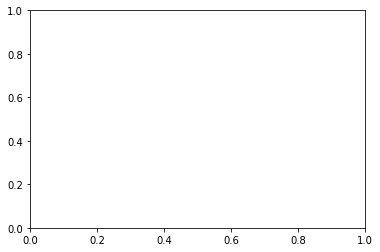

In [65]:
fig, ax = plt.subplots(1, figsize=(6,4))
ax.scatter(Xc[:,1], Xc[:,0])
ax.set_xlabel("Juveniles")
ax.set_ylabel("Adults")

# ax[1].plot(Xr[::5,1])
# ax[1].set_ylabel("Juveniles")
# ax[2].plot(Xr[::5,0])
# ax[2].set_ylabel("Adults")
plt.tight_layout()
plt.show()

In [66]:
poincareT(Xc[:,1],xlabel="Juveniles(t)", ylabel="Juveniles(t-1)")

NameError: name 'Xc' is not defined

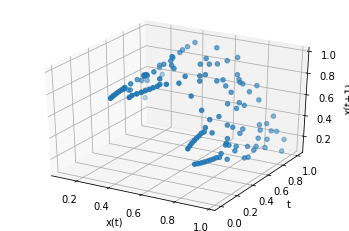

In [67]:
poincareT(Xr)

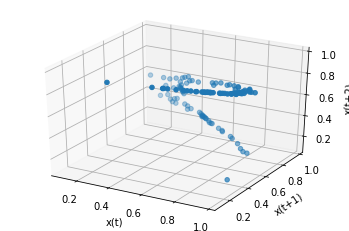

In [68]:
poincare3d(Xr)

In [69]:
# Monotonic Trend
# Xr = (np.linspace(0,8,num=tlen) + np.cos(np.linspace(0,80,num=tlen))).reshape((tlen,1))

"""
# Rosenzweig MacArthur
h2 = lambda t : 2.0 - 1.0 * t / end

Xr = standardize(odeint(RosenzweigMacArthurP, t0, tr, args=(h2,)))[::reduction,0,None]
# Xr = standardize(odeint(RosenzweigMacArthur, t0, t, args=(h2,)))[::reduction,:]
"""

# period of Lorenz at beta=0.5 is about 3.5
"""
rho = lambda t: 28 # + 16 * t / end # rho = 28.0
sigma = lambda t: 10 # + 8 * t / end # sigma = 10.0
beta = lambda t: 1.5 + 3 * t / end #1 * np.sin(np.pi * t / end)# beta = 8.0 / 3.0

states = odeint(ms.LorenzP, t0, tr, args=(rho, sigma, beta))
Xr = standardize(states)[::reduction, 0, None]
print(Xr.shape, t.shape)
"""
"""
gstates = standardize(odeint(RosenzweigMacArthur, np.array([0.8,0.1,9]), t*2))[:,1,None]
figG, axG = plt.subplots(1)
axG.plot(gstates)
plt.show()
"""

"""
# Lorenz 96
F = lambda t : 7 + (2 ** 5) * t / end
# F = lambda t : 12 # + 5 * np.sin(2 * np.pi * t / end)
# F = lambda t : 7 + 4 * gstates[np.array((tlen-100)*t/end,dtype=int)]

Xr = standardize(odeint(Lorenz96P, t0, tr, args=(F,)))[::reduction,0,None]
"""

"""
# Rossler
a = lambda t : 0.2 # + 0.2 * t / end
b = lambda t : 0.2 # + 1 * t / end
c = lambda t : 2.7 + 10 * t / end + np.sin(20*np.pi*t/end)
Xr = standardize(odeint(ms.RosslerP, t0, tr, args=(a,b,c)))[::reduction, 0, None]
"""

"""
# Logistic Map
# r = lambda t: 3 + 1 # np.sin(np.pi * t / tlen)
r = lambda t: 3.3 + 0.7 * t / tlen
Xr = np.zeros((tlen,1))
Xr[0,0] = t0
for i in range(1,tlen):
    Xr[i,0] = r(i) * Xr[i-1,0] * (1 - Xr[i-1,0])

Xr = Xr[settlingTime:]
"""

# Constant Map
# Xr = 2 + 0.01* rand.uniform(size=(tlen-settlingTime,1))

# Random
# Xr = rand.uniform(size=(tlen-settlingTime,1))

# Sinusoidal Motion
# Xr = np.sin(t).reshape(t.shape[0],1)



'\n# Logistic Map\n# r = lambda t: 3 + 1 # np.sin(np.pi * t / tlen)\nr = lambda t: 3.3 + 0.7 * t / tlen\nXr = np.zeros((tlen,1))\nXr[0,0] = t0\nfor i in range(1,tlen):\n    Xr[i,0] = r(i) * Xr[i-1,0] * (1 - Xr[i-1,0])\n\nXr = Xr[settlingTime:]\n'

In [70]:
print(Xr.shape, tr.shape)

(128, 1) (128,)


In [71]:
# FROM DATA

"""
file = "GPDD.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
states = data.to_numpy()

Xr = np.log(states[:,2,None]+1)
tr = states[:,3] - np.min(states[:,3])
tlen = states.shape[0]
"""
# END FROM DATA

'\nfile = "GPDD.csv"\ndata = pd.read_csv(file,encoding="utf-8",na_filter=False)\nstates = data.to_numpy()\n\nXr = np.log(states[:,2,None]+1)\ntr = states[:,3] - np.min(states[:,3])\ntlen = states.shape[0]\n'

In [72]:

""" UPDATE DRIVERS HERE """

digiDrivers = [r]

"""
gtsr = np.zeros((Xr.shape[0], ndrivers))
for ind in range(len(digiDrivers)):
    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax
    gtsr[:,ind] = tmp
"""
# gtsr = h2(t)
gtsr = r(t) # driverArray
# gtsr = c(t)

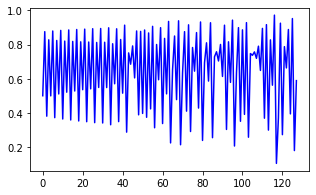

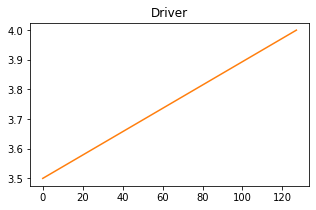

In [73]:
fig2 = plt.figure(2,figsize=(5,3))

if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
    
""" 
ax2 = fig2.gca(projection="3d")
ax2.plot(t[settlingTime:],Xr[:,0],Xr[:,1])
ax2.set_xlabel("Time")
ax2.set_ylabel("Species 1 (standardized)")
ax2.set_zlabel("Species 2 (standardized)")
"""
# ax2.set_title("Rosenzweig MacArthur")
plt.savefig("Raw Data")

if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(5,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])

plt.savefig("Individual Dimensions")
        
if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(5,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver")
        axD.plot(gtsr, c="tab:orange")
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
            
    plt.savefig("Drivers")
        
plt.show()

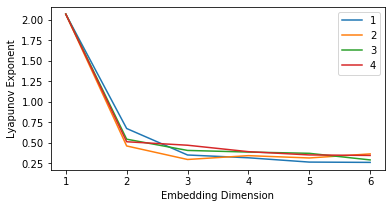

In [74]:
FNNplot(Xr, 5, 4)

In [93]:
predictionHorizon = 1
numLags = 1
lagStep = 1

X, Y, tx = delayEmbed(Xr, predictionHorizon, numLags, lagStep, t=t)

In [94]:
print(X.shape, Y.shape, tx.shape)

(126, 2) (126, 1) (126,)


In [95]:
np.power(1-0.9, (t - np.min(t))/np.ptp(t))

array([1.        , 0.98203278, 0.96438838, 0.947061  , 0.93004495,
       0.91333462, 0.89692454, 0.8808093 , 0.8649836 , 0.84944225,
       0.83418013, 0.81919223, 0.80447363, 0.79001947, 0.77582502,
       0.7618856 , 0.74819663, 0.73475362, 0.72155214, 0.70858785,
       0.69585649, 0.68335389, 0.67107592, 0.65901855, 0.64717782,
       0.63554983, 0.62413076, 0.61291687, 0.60190446, 0.59108991,
       0.58046966, 0.57004024, 0.5597982 , 0.54974018, 0.53986288,
       0.53016304, 0.52063748, 0.51128308, 0.50209674, 0.49307546,
       0.48421626, 0.47551624, 0.46697254, 0.45858234, 0.45034289,
       0.44225148, 0.43430545, 0.42650218, 0.41883913, 0.41131375,
       0.40392359, 0.3966662 , 0.38953921, 0.38254027, 0.37566709,
       0.3689174 , 0.36228898, 0.35577965, 0.34938728, 0.34310976,
       0.33694503, 0.33089106, 0.32494587, 0.3191075 , 0.31337402,
       0.30774356, 0.30221427, 0.29678432, 0.29145193, 0.28621534,
       0.28107285, 0.27602275, 0.27106339, 0.26619313, 0.26141

<IPython.core.display.Javascript object>


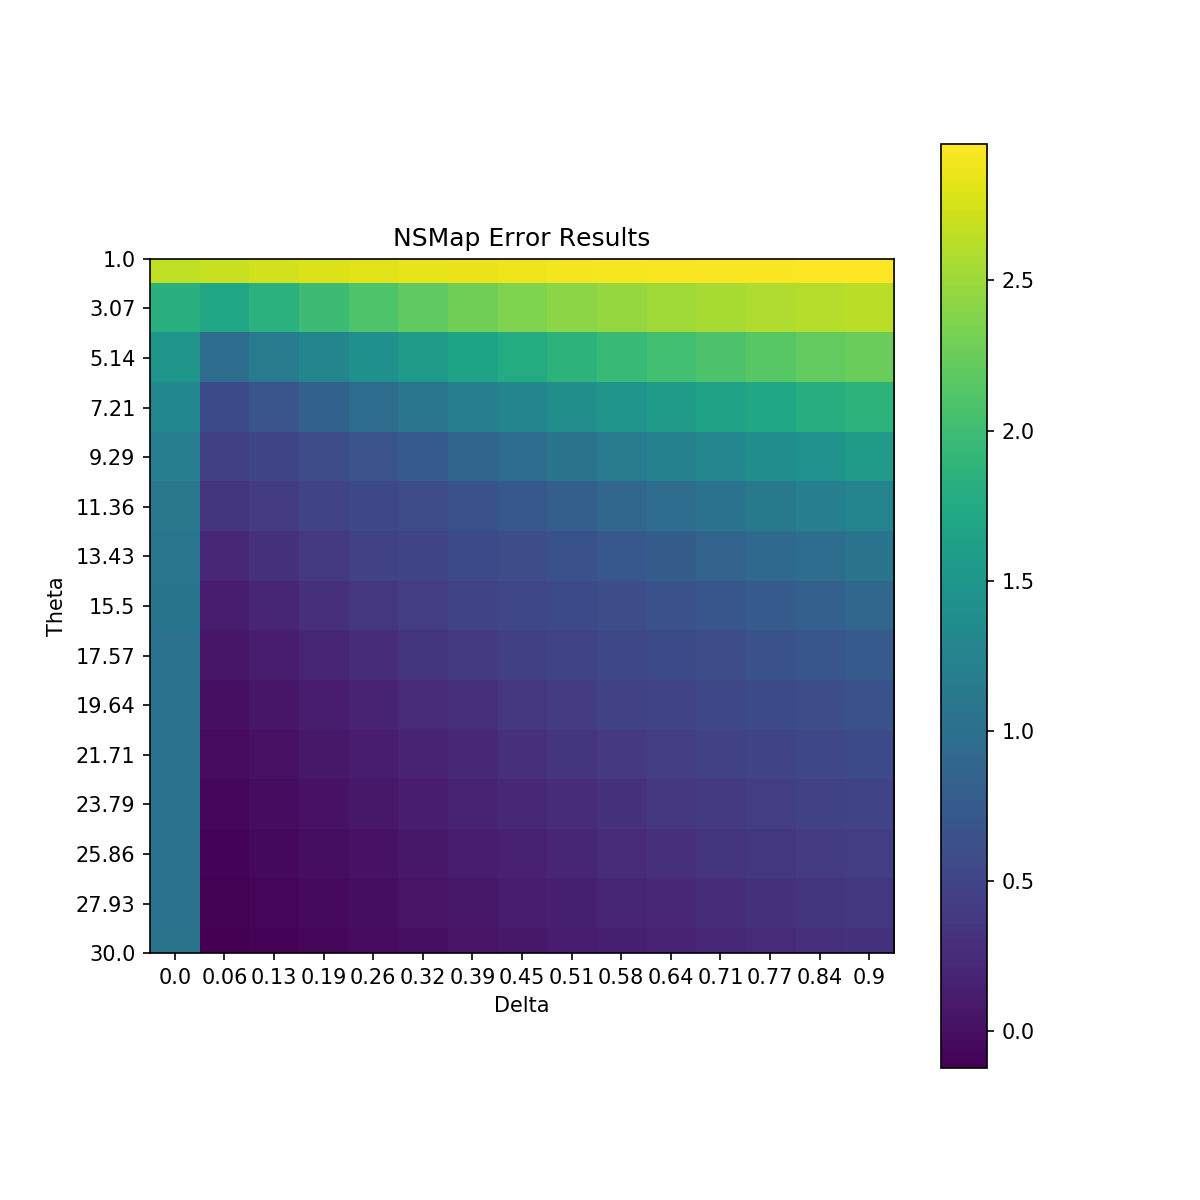

Min SMap Error: 2.8401300484190757, Min NSMap Error: 0.8830146843803429
Improvement of NSMap: 3.2164018318813596


<IPython.core.display.Javascript object>


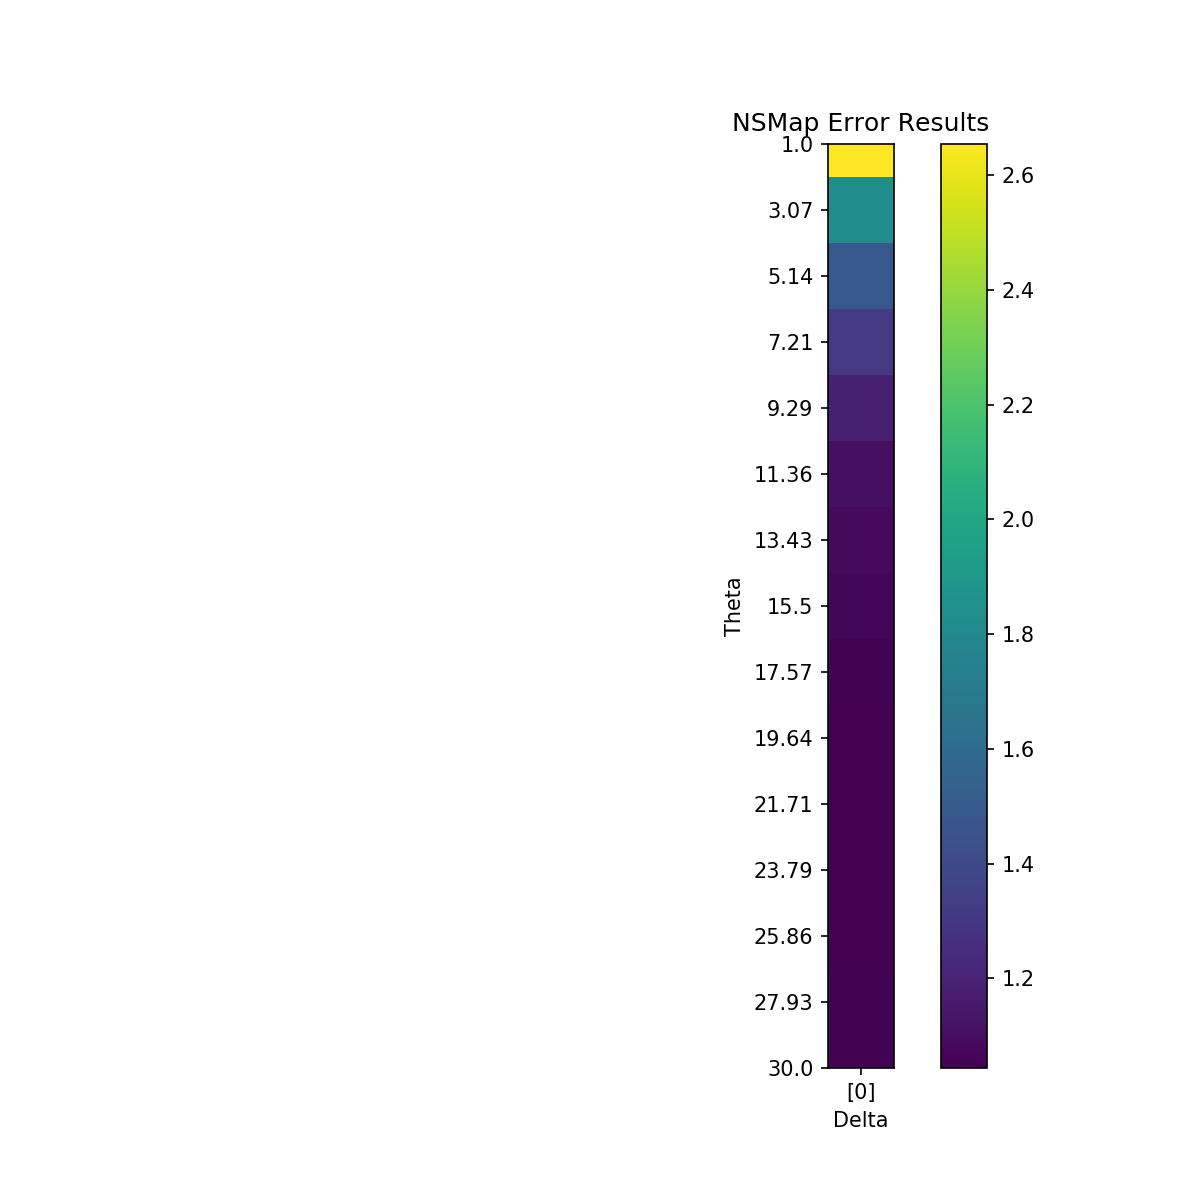

Min SMap Error: 2.8401300484190757, Min NSMap Error: 2.8401300484190757
Improvement of NSMap: 1.0
GMap Optimized Params: theta=30.0, delta=0.0642857142857143
SMap Optimized Params: theta=23.78571428571429


In [96]:
nHPvals = 15
predHorizon = 6
nTrials = int(Xr.shape[0] / 3)

thetaVals = np.linspace(1, 30, num=nHPvals)
deltaVals = np.linspace(0, 0.9, num=nHPvals)

thetaBest, deltaBest, errThetaDeltaNSMap = NSMapOptimize(X, Y, tx, thetaVals, deltaVals)
thetaBestS, _ , errThetaSMap = NSMapOptimize(X, Y, tx, thetaVals, np.array([[0]]))

print(f"GMap Optimized Params: theta={thetaBest}, delta={deltaBest}")
print(f"SMap Optimized Params: theta={thetaBestS}")

In [97]:
# print(np.trace(hatG)) 
print(f"GMap dof: {dofestimation(X,Y,tx, thetaBest, deltaBest)}")
print(f"SMap dof: {dofestimation(X,Y,tx, thetaBestS, 0)}")
# hat matrix trace = 1.7718827495393625

GMap dof: 96.18437290085996
SMap dof: 92.63418343015748


In [98]:
predictedTSG = leaveOneOut(X, Y, tx, thetaBest, deltaBest)
predictedTSS = leaveOneOut(X, Y, tx, thetaBestS, 0)

<IPython.core.display.Javascript object>


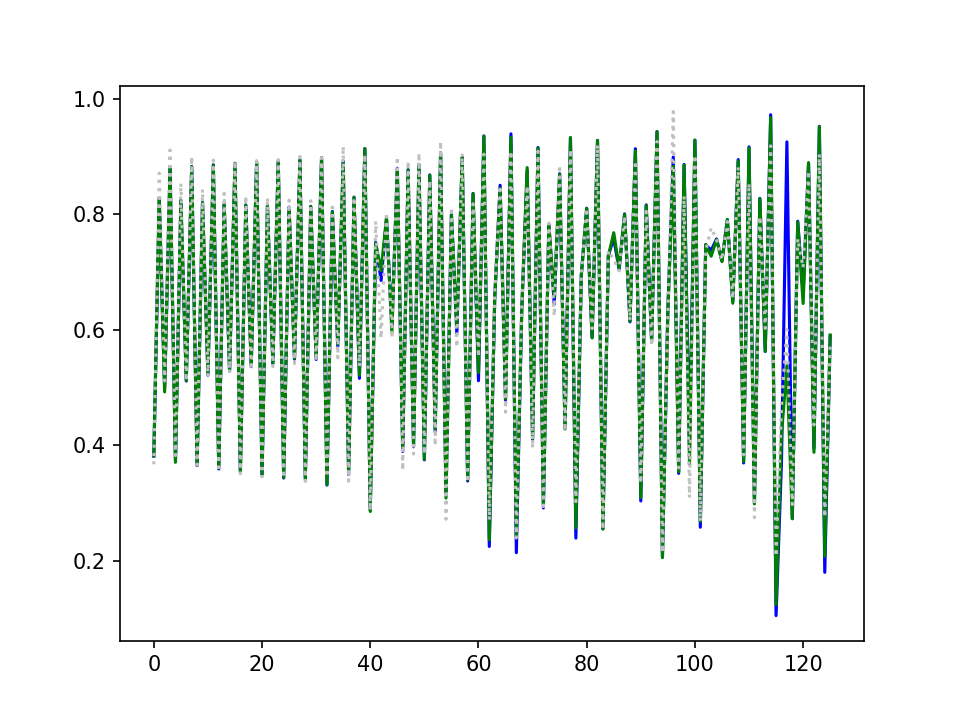

In [99]:
figLOU, axLOU = plt.subplots()
axLOU.plot(Y, c="blue")
axLOU.plot(predictedTSG, c="green", linestyle="-")
axLOU.plot(predictedTSS, c="silver", linestyle="dotted")
plt.show()

In [100]:
lambdaLR, dof = likelihoodRatioTest(X, Y, tx, thetaBestS, thetaBest, deltaBest, errThetaDeltaNSMap)


Probabiliy of SMap superiority :  0.0
LambdaLR =  147.20117469569902  dof =  3.5501894707024775


In [101]:
# SUMMARY
print(f"GMap Optimized Params: theta={thetaBest}, delta={deltaBest}")
print(f"SMap Optimized Params: theta={thetaBestS}")

print(f"GMap dof: {dofestimation(X,Y,tx, thetaBest, deltaBest)}")
print(f"SMap dof: {dofestimation(X,Y,tx, thetaBestS, 0)}")

print(f"Min SMap Error: {np.min(errThetaSMap)}, Min GMap Error: {np.min(errThetaDeltaNSMap)}")
print(f"Improvement of GMap: {np.min(errThetaSMap)/np.min(errThetaDeltaNSMap)}")

print(f"LRT Score w/ steps = {lambdaLR}, DOF difference = {dof}")
print(f"Probability of SMap Superiority: {chisig(lambdaLR, dof)}")

GMap Optimized Params: theta=30.0, delta=0.0642857142857143
SMap Optimized Params: theta=23.78571428571429
GMap dof: 96.18437290085996
SMap dof: 92.63418343015748
Min SMap Error: 2.8401300484190757, Min GMap Error: 0.8830146843803429
Improvement of GMap: 3.2164018318813596
LRT Score w/ steps = 147.20117469569902, DOF difference = 3.5501894707024775
Probability of SMap Superiority: 0.0


<IPython.core.display.Javascript object>


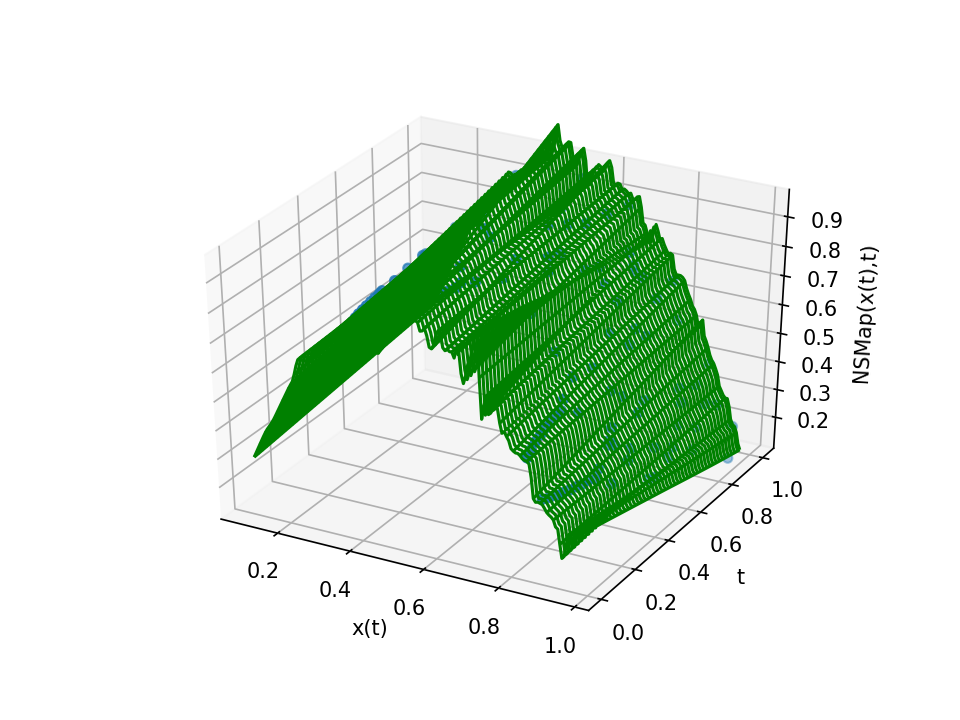

In [102]:
functionSurfaceNSMap(Xr, predictionHorizon, thetaBest, deltaBest, 150)

<IPython.core.display.Javascript object>


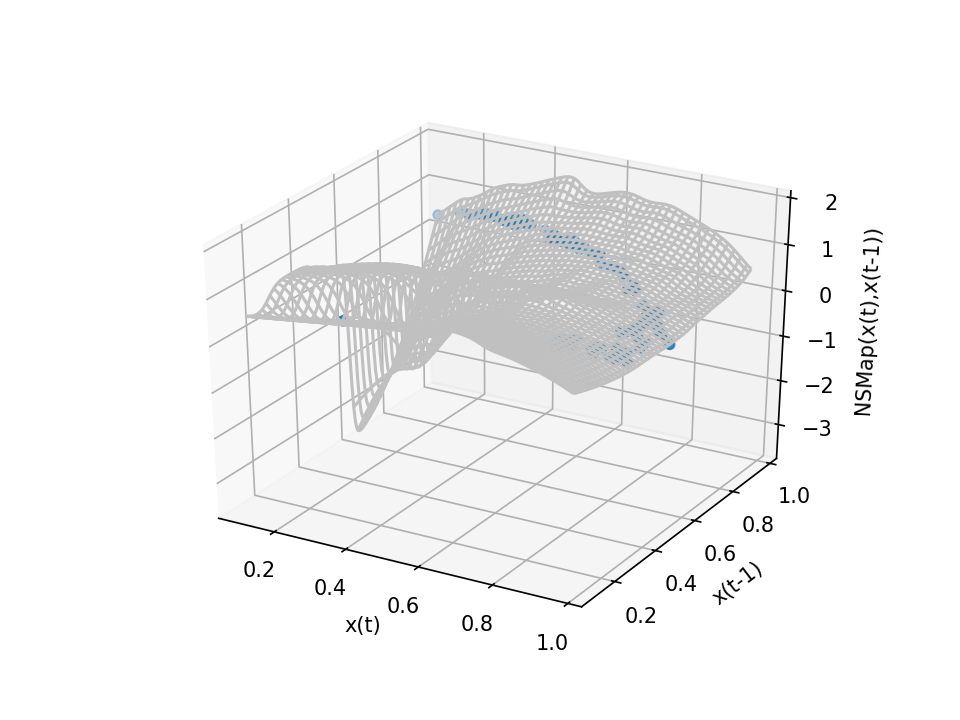

In [103]:
functionSurfaceSMap(Xr, predictionHorizon, thetaBestS, 150)